Adapted from: https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/logistic.py

In [1]:
%pylab --no-import-all inline

from pymc3 import *
import theano.tensor as T
from numpy import random, sum as nsum, ones, concatenate, newaxis, dot, arange
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [3]:
def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

Basic Logistic Regression
===

In [53]:
# Set up basic parameters
num_features = 7
n = 100000

In [54]:
# Choose random values for the actual alpha and betas
alpha_a = random.normal(size=1)

betas_a = random.normal(size = num_features)

# Create fake predictor data
predictors = random.normal(size=(n, num_features))

In [55]:
# Calculate the outcomes
outcomes = random.binomial(1, invlogit(alpha_a + np.sum(betas_a[None, :] * predictors, 1)))

In [56]:
model = Model()

with model:
    alpha = Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, num_features))
    
    p = tinvlogit(alpha+sum(betas * predictors, 1))

    o = Bernoulli(b'o', p, observed=outcomes)

(1,)
(1, 7)
(100000, 7)


In [57]:
with model:
    mu, sds, elbo = variational.advi(n=10000)

Iteration 0 [0%]: ELBO = -183969.24
Iteration 1000 [10%]: ELBO = nan
Iteration 2000 [20%]: ELBO = nan
Iteration 3000 [30%]: ELBO = nan
Iteration 4000 [40%]: ELBO = nan
Iteration 5000 [50%]: ELBO = nan
Iteration 6000 [60%]: ELBO = nan
Iteration 7000 [70%]: ELBO = nan
Iteration 8000 [80%]: ELBO = nan
Iteration 9000 [90%]: ELBO = nan
Finished [100%]: ELBO = nan


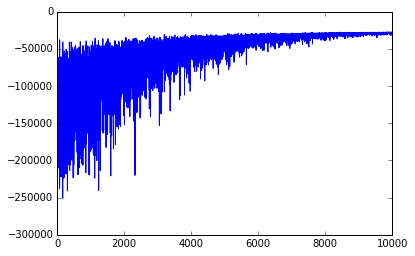

In [52]:
plt.plot(elbo[0:])

In [ ]:
with model:
    # move the chain to the MAP which should be a good starting point
    #start = find_MAP()
    #step = NUTS()

    #trace = sample(3e3, step, start)
    
    step = NUTS()

    trace = sample(4e3, step)


In [ ]:
traceplot(trace)

In [ ]:
summary(trace)

In [ ]:
alpha_a

In [ ]:
betas_a

Hierachical Logistic Regression
===

In [ ]:
# Set up basic parameters
num_markets = 4

# Need lots of data to converge
num_per_market = 15000
num_observed = num_per_market * num_markets
num_features = 5

In [ ]:
# Set up markets
market = concatenate([[i] * num_per_market for i in range(num_markets)])

In [ ]:
market

In [ ]:
# Simulate the features
predictors = np.random.normal(size=(num_observed, num_features))

In [ ]:
alpha_a = np.random.normal(size=(num_markets))
beta_a = np.random.normal(size=(num_markets, num_features))

In [ ]:
# Calculate the actual data
p = alpha_a[market] + nsum(beta_a[market] * predictors, 1)

#p = nsum(beta_a[market] * predictors, 1)

In [ ]:
# Calculate the outcomes
outcomes = np.random.binomial(1, invlogit(p))

In [ ]:
model = Model()

with model:
    # Both alpha and beta are drawn for the same distributions
    mu_alpha = Normal(b"mu_alpha", 0, 100, shape=(1))
    sigma_alpha = Uniform(b"sigma_alpha", .0, 10, testval=2.)
    
    mu_beta = Normal(b"mu_beta", 0, 100, shape=(1))
    sigma_beta = Uniform(b"sigma_beta", 0, 10, testval=2.)
    
    alpha = Normal(b'alpha', mu=mu_alpha, tau=sigma_alpha, shape=(num_markets))
    beta = Normal(b'beta', mu=mu_beta, tau=sigma_beta, shape=(num_markets, num_features))
    
    m = T.constant(market)
    print(m)
    p = tinvlogit(alpha[m] + sum(beta[m] * predictors, 1))
    #p = tinvlogit(sum(beta[m] * predictors, 1))
    
    o = Bernoulli(b'o', p, observed=outcomes)

In [ ]:
with model:
    mu, sds, elbo = variational.advi(n=10000)

In [ ]:
plt.plot(elbo[0:])

In [ ]:
mu

In [ ]:
sds

In [ ]:
with model:
    # move the chain to the MAP which should be a good starting point
    #start = find_MAP()
    #step = NUTS(scaling=start)
    #step = Slice()
#     step = NUTS()
#     trace = sample(3e4, step)
    
    step = NUTS(scaling=sds)
    trace = sample(20000, step, start=mu)


In [ ]:
traceplot(trace)

In [ ]:
summary(trace)

In [ ]:
beta_a

In [ ]:
alpha_a

In [ ]:
forestplot(trace, varnames=['mu_alpha', 'mu_beta', 'alpha', 'sigma_alpha', 'sigma_beta'])